# Assignment 2

> Tristan PERROT

## Utils

### Imports


In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from tqdm.notebook import trange

DATASET_PATH = '../Dataset/'

In [47]:
def load_batch(filename):
    """ Copied from the dataset website """
    import pickle
    with open(DATASET_PATH + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_data(filename):
    """ Read the data from the file """
    data = load_batch(filename)
    X = data[b'data'].T / 255
    y = np.array(data[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1
    return X, Y, y


def load_all_data():
    """ Load all the data """
    X, Y, y = load_data('data_batch_1')
    for i in range(2, 6):
        X_i, Y_i, y_i = load_data(f'data_batch_{i}')
        X = np.concatenate((X, X_i), axis=1)
        Y = np.concatenate((Y, Y_i), axis=1)
        y = np.concatenate((y, y_i))
    X_test_, Y_test_, y_test_ = load_data('test_batch')
    return X, Y, y, X_test_, Y_test_, y_test_

In [48]:
def compute_relative_error(grad_analytical, grad_numerical, eps=1e-9):
    """ Compute the relative error between the analytical and numerical gradients """
    return torch.max(
        torch.abs(grad_analytical - grad_numerical) / torch.clamp(
            torch.abs(grad_analytical) + torch.abs(grad_numerical) + eps, min=eps))

## Exercises

### Model


In [49]:
def compute_eta(eta_min, eta_max, t, n_s):
    t = t % (2 * n_s)
    if t < n_s:
        return eta_min + t / n_s * (eta_max - eta_min)
    else:
        return eta_max - (t - n_s) / n_s * (eta_max - eta_min)


class Classifier:
    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_1d_train, y_1d_val, y_1d_test, eta=0.001,
                 lambda_=0.0):
        self.x_train = torch.tensor(x_train, dtype=torch.float64)
        self.x_val = torch.tensor(x_val, dtype=torch.float64)
        self.x_test = torch.tensor(x_test, dtype=torch.float64)
        self.y_train = torch.tensor(y_train, dtype=torch.float64)
        self.y_val = torch.tensor(y_val, dtype=torch.float64)
        self.y_test = torch.tensor(y_test, dtype=torch.float64)
        self.y_1d_train = torch.tensor(y_1d_train, dtype=torch.float64)
        self.y_1d_val = torch.tensor(y_1d_val, dtype=torch.float64)
        self.y_1d_test = torch.tensor(y_1d_test, dtype=torch.float64)

        self.eta = eta
        self.lambda_ = lambda_

        self.W = []
        self.b = []
        self.z1 = None
        self.h = None
        self.z2 = None
        self.p = None

        self.costs_train = []
        self.costs_val = []
        self.losses_train = []
        self.losses_val = []
        self.accuracies_train = []
        self.accuracies_val = []

    def keep_n_data(self, n):
        self.x_train = self.x_train[:, :n]
        self.y_train = self.y_train[:, :n]
        self.y_1d_train = self.y_1d_train[:n]
        self.x_val = self.x_val[:, :n]
        self.y_val = self.y_val[:, :n]
        self.y_1d_val = self.y_1d_val[:n]
        self.x_test = self.x_test[:, :n]
        self.y_test = self.y_test[:, :n]
        self.y_1d_test = self.y_1d_test[:n]

    def keep_n_dim(self, n):
        self.x_train = self.x_train[:n]
        self.x_val = self.x_val[:n]
        self.x_test = self.x_test[:n]
        self.y_val = self.y_val[:n]
        self.y_train = self.y_train[:n]
        self.y_test = self.y_test[:n]
        self.y_1d_train = self.y_1d_train[:n]
        self.y_1d_val = self.y_1d_val[:n]
        self.y_1d_test = self.y_1d_test[:n]

    def preprocess(self):
        mean_X = torch.mean(self.x_train, dim=1, keepdim=True)
        std_X = torch.std(self.x_train, dim=1, keepdim=True)
        self.x_train = (self.x_train - mean_X) / std_X
        self.x_val = (self.x_val - mean_X) / std_X
        self.x_test = (self.x_test - mean_X) / std_X

    def initialize_weights(self, hidden_size):
        features = self.x_train.shape[0]
        outputs = self.y_train.shape[0]

        W1 = torch.randn(hidden_size, features,
                         dtype=self.x_train.dtype) / math.sqrt(features)
        b1 = torch.zeros(hidden_size, 1, dtype=self.x_train.dtype)
        W2 = torch.randn(outputs, hidden_size,
                         dtype=self.x_train.dtype) / math.sqrt(hidden_size)
        b2 = torch.zeros(outputs, 1, dtype=self.x_train.dtype)
        W1.requires_grad = True
        b1.requires_grad = True
        W2.requires_grad = True
        b2.requires_grad = True
        self.W = [W1, W2]
        self.b = [b1, b2]

    def forward(self, x, W1, b1, W2, b2):
        self.z1 = W1 @ x + b1
        self.h = torch.relu(self.z1)
        self.z2 = W2 @ self.h + b2
        self.p = torch.softmax(self.z2, dim=0)

    def cost(self, x, y, W1, b1, W2, b2):
        m = x.shape[1]
        self.forward(x, W1, b1, W2, b2)
        loss = -torch.sum(y * torch.log(self.p)) / m
        reg = self.lambda_ * (torch.sum(W1 ** 2) + torch.sum(W2 ** 2))
        return loss + reg, loss

    def cost_grad(self, x, y):
        m = x.shape[1]
        self.forward(x, self.W[0], self.b[0], self.W[1], self.b[1])
        dZ2 = self.p - y
        dW2 = dZ2 @ self.h.T / m + 2 * self.lambda_ * self.W[1]
        db2 = torch.sum(dZ2, dim=1, keepdim=True) / m
        dH = self.W[1].T @ dZ2
        dZ1 = dH * (self.z1 > 0)
        dW1 = dZ1 @ x.T / m + 2 * self.lambda_ * self.W[0]
        db1 = torch.sum(dZ1, dim=1, keepdim=True) / m
        return dW1, db1, dW2, db2

    def accuracy(self, x, y):
        self.forward(x, self.W[0], self.b[0], self.W[1], self.b[1])
        correct = torch.sum(torch.argmax(y, dim=0) ==
                            torch.argmax(self.p, dim=0))
        return correct.item() / x.shape[1]

    def compute_grads_num(self, X, Y, W, b, h):
        grad_W = [torch.zeros_like(w) for w in W]
        grad_b = [torch.zeros_like(bi) for bi in b]

        c, _ = self.cost(X, Y, W[0], b[0], W[1], b[1])

        for j in range(len(b)):
            for i in range(len(b[j])):
                b_try = [bi.clone() for bi in b]
                b_try[j][i] += h
                c2, _ = self.cost(X, Y, W[0], b_try[0], W[1], b_try[1])
                grad_b[j][i] = (c2 - c) / h
        for j in range(len(W)):
            for i in range(np.prod(W[j].shape)):
                W_try = [wi.clone() for wi in W]
                idx = np.unravel_index(i, W[j].shape)
                W_try[j][idx] += h
                c2, _ = self.cost(X, Y, W_try[0], b[0], W_try[1], b[1])
                grad_W[j][idx] = (c2 - c) / h

        return grad_b, grad_W

    def check_grad(self):
        dW1, db1, dW2, db2 = self.cost_grad(self.x_train, self.y_train)

        grad_b, grad_W = self.compute_grads_num(
            self.x_train, self.y_train, self.W, self.b, 1e-5)
        db1_num, dW1_num = grad_b[0], grad_W[0]
        db2_num, dW2_num = grad_b[1], grad_W[1]

        print('Between analytical and numerical gradients:')
        print('Difference for W1:', torch.max(torch.abs(dW1 - dW1_num)))
        print('Difference for b1:', torch.max(torch.abs(db1 - db1_num)))
        print('Difference for W2:', torch.max(torch.abs(dW2 - dW2_num)))
        print('Difference for b2:', torch.max(torch.abs(db2 - db2_num)))
        print('Relative error for W1:', compute_relative_error(dW1, dW1_num))
        print('Relative error for b1:', compute_relative_error(db1, db1_num))
        print('Relative error for W2:', compute_relative_error(dW2, dW2_num))
        print('Relative error for b2:', compute_relative_error(db2, db2_num))

        cost, _ = self.cost(self.x_train, self.y_train,
                            self.W[0], self.b[0], self.W[1], self.b[1])
        cost.backward()
        grad_W1 = self.W[0].grad
        grad_b1 = self.b[0].grad
        grad_W2 = self.W[1].grad
        grad_b2 = self.b[1].grad

        print('\nBetween analytical and torch gradients:')
        print('Difference for W1:', torch.max(torch.abs(dW1 - grad_W1)))
        print('Difference for b1:', torch.max(torch.abs(db1 - grad_b1)))
        print('Difference for W2:', torch.max(torch.abs(dW2 - grad_W2)))
        print('Difference for b2:', torch.max(torch.abs(db2 - grad_b2)))
        print('Relative error for W1:', compute_relative_error(dW1, grad_W1))
        print('Relative error for b1:', compute_relative_error(db1, grad_b1))
        print('Relative error for W2:', compute_relative_error(dW2, grad_W2))
        print('Relative error for b2:', compute_relative_error(db2, grad_b2))

        print('\nBetween torch and numerical gradients:')
        print('Difference for W1:', torch.max(torch.abs(grad_W1 - dW1_num)))
        print('Difference for b1:', torch.max(torch.abs(grad_b1 - db1_num)))
        print('Difference for W2:', torch.max(torch.abs(grad_W2 - dW2_num)))
        print('Difference for b2:', torch.max(torch.abs(grad_b2 - db2_num)))
        print('Relative error for W1:', compute_relative_error(grad_W1, dW1_num))
        print('Relative error for b1:', compute_relative_error(grad_b1, db1_num))
        print('Relative error for W2:', compute_relative_error(grad_W2, dW2_num))
        print('Relative error for b2:', compute_relative_error(grad_b2, db2_num))

        # Reset gradients
        self.W[0].grad.zero_()
        self.b[0].grad.zero_()
        self.W[1].grad.zero_()
        self.b[1].grad.zero_()

    def mini_batch_gd(self, batch_size, n_epochs):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        p_bar = trange(n_epochs)
        for epoch in p_bar:
            shuffle_idx = torch.randperm(n)
            x_train = self.x_train[:, shuffle_idx]
            y_train = self.y_train[:, shuffle_idx]
            for i in range(n_batch):
                start = i * batch_size
                end = min((i + 1) * batch_size, n)
                x_batch = x_train[:, start:end]
                y_batch = y_train[:, start:end]
                dW1, db1, dW2, db2 = self.cost_grad(x_batch, y_batch)
                with torch.no_grad():
                    self.W[0] -= self.eta * dW1
                    self.b[0] -= self.eta * db1
                    self.W[1] -= self.eta * dW2
                    self.b[1] -= self.eta * db2
            cost_train, loss_train = self.cost(
                self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
            cost_val, loss_val = self.cost(self.x_val, self.y_val,
                                           self.W[0], self.b[0], self.W[1], self.b[1])
            self.costs_train.append(cost_train.item())
            self.costs_val.append(cost_val.item())
            self.losses_train.append(loss_train.item())
            self.losses_val.append(loss_val.item())
            accuracy_train = self.accuracy(self.x_train, self.y_train)
            accuracy_val = self.accuracy(self.x_val, self.y_val)
            self.accuracies_train.append(accuracy_train)
            self.accuracies_val.append(accuracy_val)
            p_bar.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {
                cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epochs}')

    def mini_batch_gd_cyclic(self, batch_size, n_s, n_cycles, pbar=True):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        n_epoch = math.ceil(2 * n_s / n_batch)
        t = 0
        p_bar = trange(n_cycles) if pbar else range(n_cycles)
        for cycle in p_bar:
            p_bar.set_description(
                f'Cycle: {cycle + 1}/{n_cycles}') if pbar else None
            p_bar2 = trange(n_epoch, leave=False) if pbar else range(n_epoch)
            for epoch in p_bar2:
                shuffle_idx = torch.randperm(n)
                x_train = self.x_train[:, shuffle_idx]
                y_train = self.y_train[:, shuffle_idx]
                for i in range(n_batch):
                    start = i * batch_size
                    end = min((i + 1) * batch_size, n)
                    x_batch = x_train[:, start:end]
                    y_batch = y_train[:, start:end]
                    dW1, db1, dW2, db2 = self.cost_grad(x_batch, y_batch)
                    eta = compute_eta(1e-5, 1e-1, t, n_s)
                    with torch.no_grad():
                        self.W[0] -= eta * dW1
                        self.b[0] -= eta * db1
                        self.W[1] -= eta * dW2
                        self.b[1] -= eta * db2
                    t += 1
                cost_train, loss_train = self.cost(
                    self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
                cost_val, loss_val = self.cost(
                    self.x_val, self.y_val, self.W[0], self.b[0], self.W[1], self.b[1])
                self.costs_train.append(cost_train.item())
                self.costs_val.append(cost_val.item())
                self.losses_train.append(loss_train.item())
                self.losses_val.append(loss_val.item())
                accuracy_train = self.accuracy(self.x_train, self.y_train)
                accuracy_val = self.accuracy(self.x_val, self.y_val)
                self.accuracies_train.append(accuracy_train)
                self.accuracies_val.append(accuracy_val)
                p_bar2.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {
                                       cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epoch}') if pbar else None

    def plot_costs_acc(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].plot(self.costs_train, label='Train')
        ax[0].plot(self.costs_val, label='Validation')
        ax[0].set_title('Cost vs Epochs')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Cost')
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(self.losses_train, label='Train')
        ax[1].plot(self.losses_val, label='Validation')
        ax[1].set_title('Loss vs Epochs')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[1].legend()
        ax[1].grid()
        ax[2].plot(self.accuracies_train, label='Train')
        ax[2].plot(self.accuracies_val, label='Validation')
        ax[2].set_title('Accuracy vs Epochs')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Accuracy')
        ax[2].legend()
        ax[2].grid()
        fig.tight_layout()
        print('Train Accuracy:', self.accuracies_train[-1])
        print('Validation Accuracy:', self.accuracies_val[-1])
        print('Test Accuracy:', self.accuracy(self.x_test, self.y_test))
        plt.show()

## Exercice 1 & 2


In [50]:
X_train, Y_train, y_train = load_data('data_batch_1')
X_val, Y_val, y_val = load_data('data_batch_2')
X_test, Y_test, y_test = load_data('test_batch')

n = 20
dim = 50

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.001, lambda_=0.0)
classifier.keep_n_data(n)
classifier.keep_n_dim(dim)
classifier.preprocess()
classifier.initialize_weights(n)
classifier.check_grad()

Between analytical and numerical gradients:
Difference for W1: tensor(2.1444e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b1: tensor(1.5904e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for W2: tensor(1.7681e-06, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b2: tensor(6.3831e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for W1: tensor(0.0034, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for b1: tensor(9.6688e-06, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for W2: tensor(0.0002, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for b2: tensor(7.9399e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)

Between analytical and torch gradients:
Difference for W1: tensor(3.4694e-17, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b1: tensor(1.3878e-17, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for W2: tensor(5.5511e-17, dtype=torch.float64, grad_fn=<MaxBackwa

In [51]:
n = 100
hidden_size = 50

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=0.0)
classifier.keep_n_data(n)
classifier.preprocess()
classifier.initialize_weights(hidden_size)
classifier.mini_batch_gd(batch_size=50, n_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Train Accuracy: 1.0
Validation Accuracy: 0.29
Test Accuracy: 0.19


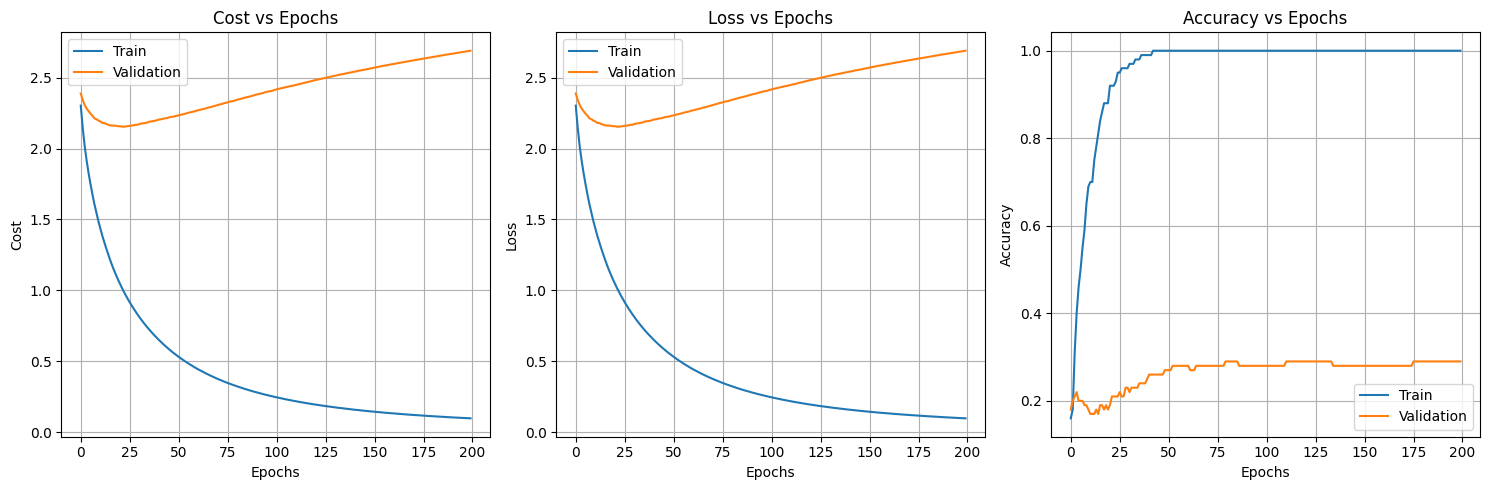

In [52]:
classifier.plot_costs_acc()

## Exercice 3


In [53]:
classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.01)
classifier.preprocess()
classifier.initialize_weights(hidden_size=50)
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=500, n_cycles=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Accuracy: 0.6093
Validation Accuracy: 0.4603
Test Accuracy: 0.4586


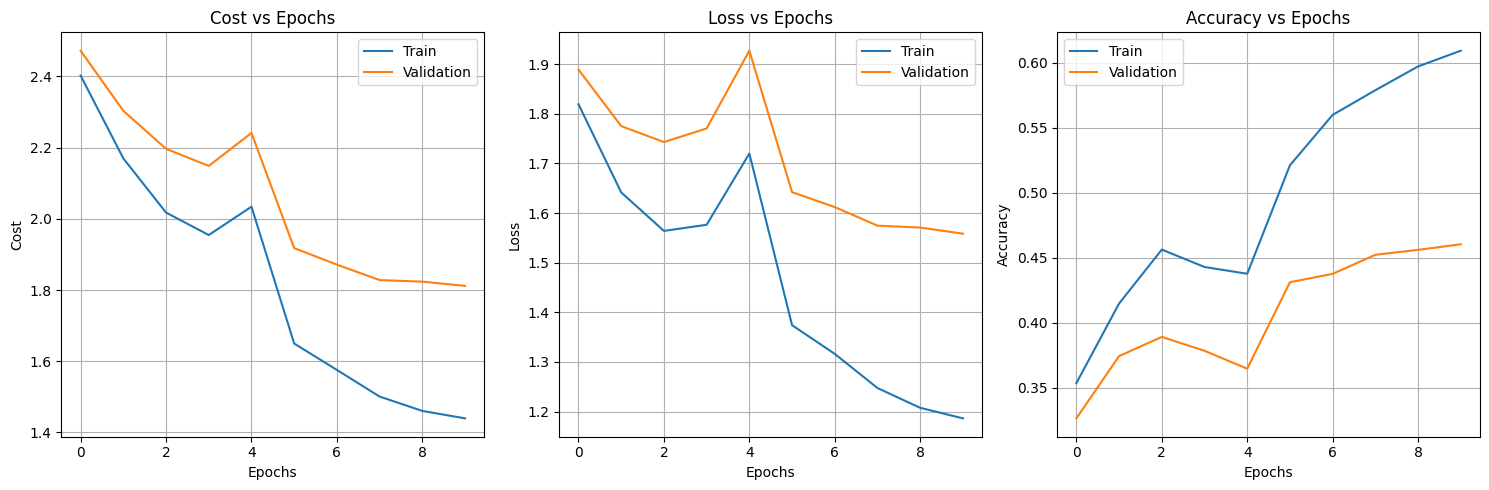

In [54]:
classifier.plot_costs_acc()

## Exercice 4


In [55]:
classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.01)
classifier.preprocess()
classifier.initialize_weights(hidden_size=50)
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=800, n_cycles=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Accuracy: 0.7166
Validation Accuracy: 0.4639
Test Accuracy: 0.4701


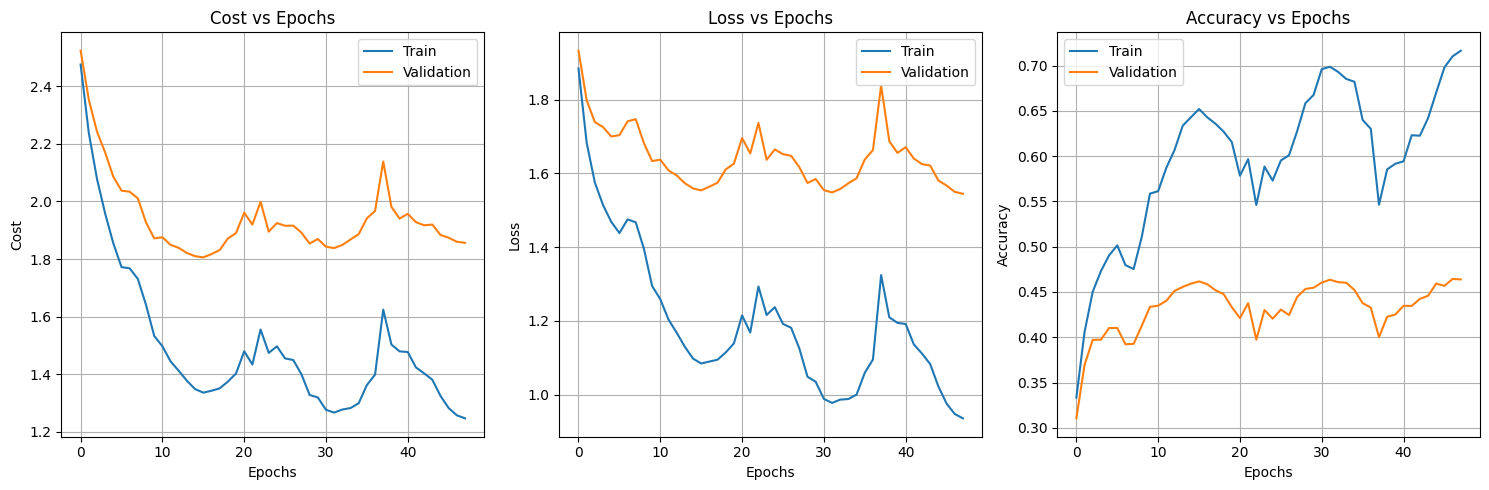

In [56]:
classifier.plot_costs_acc()

### Coarse-to-fine random search


In [57]:
X, Y, y, X_test, Y_test, y_test = load_all_data()

X_train = X[:, :45000]
Y_train = Y[:, :45000]
y_train = y[:45000]
X_val = X[:, 45000:]
Y_val = Y[:, 45000:]
y_val = y[45000:]

print('Train:', X_train.shape, Y_train.shape, y_train.shape)
print('Validation:', X_val.shape, Y_val.shape, y_val.shape)

Train: (3072, 45000) (10, 45000) (45000,)
Validation: (3072, 5000) (10, 5000) (5000,)


In [58]:
def random_search(n_iter, n_cycles, batch_size, l_min, l_max):
    n_batch = math.ceil(X_train.shape[1] / batch_size)
    n_s = 2 * math.floor(X_train.shape[1] / n_batch)
    accuracies = []
    lambdas = []
    pbar = trange(n_iter)
    for i in pbar:
        l = l_min + torch.rand(1) * (l_max - l_min)
        lambda_ = 10 ** l
        classifier = Classifier(X_train, X_val, X_test, Y_train,
                                Y_val, Y_test, y_train, y_val, y_test, eta=None, lambda_=lambda_)
        classifier.preprocess()
        classifier.initialize_weights(hidden_size=50)
        classifier.mini_batch_gd_cyclic(
            batch_size=batch_size, n_s=n_s, n_cycles=n_cycles, pbar=False)
        accuracies.append(classifier.accuracy(
            classifier.x_val, classifier.y_val))
        lambdas.append(lambda_)
        pbar.set_description(f'Iter: {i + 1}/{n_iter}')
    return accuracies, lambdas

#### Coarse search

In [59]:
accuracies, lambdas = random_search(20, 2, 100, -5, -1)
# Save the accuracies and lambdas in a file
torch.save(accuracies, 'accuracies_coarse.pth')
torch.save(lambdas, 'lambdas_coarse.pth')
# Best lambda
best_lambda = lambdas[np.argmax(accuracies)]
print('Best lambda:', best_lambda, 'with accuracy:', max(accuracies))

  0%|          | 0/20 [00:00<?, ?it/s]

Best lambda: tensor([0.0013]) with accuracy: 0.4738


In [61]:
# Load the accuracies and lambdas
accuracies = torch.load('accuracies_coarse.pth')
lambdas = torch.load('lambdas_coarse.pth')

# Ranks the lambdas based on the accuracies descending
idx = np.argsort(accuracies)[::-1]
lambdas = [lambdas[i] for i in idx]
accuracies = [accuracies[i] for i in idx]

# Print the top 5 lambdas
print('Top 5 lambdas:')
for i in range(5):
    print(f'Lambda: {lambdas[i].item():.4}, Accuracy: {accuracies[i]}')

Top 5 lambdas:
Lambda: 0.001299, Accuracy: 0.4738
Lambda: 0.0006152, Accuracy: 0.4716
Lambda: 0.005685, Accuracy: 0.469
Lambda: 0.0003537, Accuracy: 0.4686
Lambda: 0.001611, Accuracy: 0.4678


#### Fine search

In [64]:
# Get the l_min and l_max from the 5 best lambdas
lambda_min = min(lambdas[:5])
lambda_max = max(lambdas[:5])
print('Lambda min:', lambda_min)
print('Lambda max:', lambda_max)
l_min = math.log10(lambda_min)
l_max = math.log10(lambda_max)

accuracies, lambdas = random_search(20, 6, 100, l_min, l_max)
# Save the accuracies and lambdas in a file
torch.save(accuracies, 'accuracies_fine.pth')
torch.save(lambdas, 'lambdas_fine.pth')
# Best lambda
best_lambda = lambdas[np.argmax(accuracies)]
print('Best lambda:', best_lambda, 'with accuracy:', max(accuracies))


Lambda min: tensor([0.0004])
Lambda max: tensor([0.0057])


  0%|          | 0/20 [00:00<?, ?it/s]

Best lambda: tensor([0.0011]) with accuracy: 0.504


In [65]:
# Load the accuracies and lambdas
accuracies = torch.load('accuracies_fine.pth')
lambdas = torch.load('lambdas_fine.pth')

# Ranks the lambdas based on the accuracies descending
idx = np.argsort(accuracies)[::-1]
lambdas = [lambdas[i] for i in idx]
accuracies = [accuracies[i] for i in idx]

# Print the top 5 lambdas
print('Top 5 lambdas:')
for i in range(5):
    print(f'Lambda: {lambdas[i].item():.4}, Accuracy: {accuracies[i]}')


Top 5 lambdas:
Lambda: 0.00107, Accuracy: 0.504
Lambda: 0.001909, Accuracy: 0.5006
Lambda: 0.001176, Accuracy: 0.5
Lambda: 0.0005455, Accuracy: 0.4998
Lambda: 0.005269, Accuracy: 0.4992
